In [1]:
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def consecutive_count(lcfile, startdate, enddate, verbose=False):
    
    # Constructing dataframe of all nights 
    df = pd.DataFrame({'mjd': np.arange(startdate,enddate+1)})
    
    # Putting relevant columns from light curve file into temp dataframe
    lc = pd.DataFrame()
    lc['mjd'] = round(lcfile['mjd'])
    lc['band'] = lcfile['band']
    lc['good'] = lcfile['good_detection']

    # Merging light curve data into all nights dataframe 
    dfmerge = pd.merge(df, lc, how='outer', on=['mjd'])

    dfmerge['detection_i'] = dfmerge.apply(lambda row: True if row['band'] == 'i' else False, axis=1)
    dfmerge['good_i'] = dfmerge.apply(lambda row: True if row['band'] == 'i' and row['good'] == True else False, axis=1)

    dfmerge['detection_g'] = dfmerge.apply(lambda row: True if row['band'] == 'g' else False, axis=1)
    dfmerge['good_g'] = dfmerge.apply(lambda row: True if row['band'] == 'g' and row['good'] == True else False, axis=1)

    del dfmerge['band'], dfmerge['good']

    dfm = dfmerge.groupby(['mjd']).sum()
    dfm['detection_i'] = dfm['detection_i'].astype(int)
    dfm['good_i'] = dfm['good_i'].astype(int)
    dfm['detection_g'] = dfm['detection_g'].astype(int)
    dfm['good_g'] = dfm['good_g'].astype(int)

    if verbose:
        print('Detections over all nights')
        print(dfm)
    
    # Counting consecutive i band detections 
    ibanddet = dfm['detection_i']
    ibandgood = dfm['good_i']
    ibandboth = ibanddet & ibandgood
    icount = ''.join(ibandboth.astype('str').tolist()).split('0')
    icountsum = [int(np.sum([int(digit) for digit in num])) for num in icount]
    
    if verbose:
        print('Max number of consecutive i band detections:',max(icountsum))
    
    # Counting consecutive i band detections with one hole
    icountsum2 = []
    if len(icountsum) > 1:
        for i,num in enumerate(icountsum[:-1]):
            x = icountsum[i] + icountsum[i+1]
            icountsum2.append(x)
        if verbose:
            print('Max number of consecutive i band detections w/ one hole:', max(icountsum2))
    else:
        icountsum2 = icountsum
        if verbose:
            print('Max number of consecutive i band detections w/ one hole:', max(icountsum2))

    # Counting consecutive g band detections
    gbanddet = dfm['detection_g']
    gbandgood = dfm['good_g']
    gbandboth = gbanddet & gbandgood
    gcount = ''.join(gbandboth.astype('str').tolist()).split('0')
    gcountsum = [int(np.sum([int(digit) for digit in num])) for num in gcount]

    if verbose:
        print('Max number of consecutive g band detections:', max(gcountsum))

    # Counting consecutive g band detections with one hole
    gcountsum2 = []
    if len(gcountsum) > 1:
        for i,num in enumerate(gcountsum[:-1]):
            x = gcountsum[i] + gcountsum[i+1]
            gcountsum2.append(x)
        if verbose:
            print('Max number of consecutive g band detections w/ one hole:', max(gcountsum2))
    else:
        gcountsum2 = gcountsum
        if verbose:
            print('Max number of consecutive g band detections w/ one hole:', max(gcountsum2))

    # Counting consecutive detections in both i and g bands
    igbandboth = (ibanddet & ibandgood) & (gbanddet & gbandgood)
    igcount = ''.join(igbandboth.astype('str').tolist()).split('0')
    igcountsum = [int(np.sum([int(digit) for digit in num])) for num in igcount]

    if verbose:
        print('Max number of consecutive g band detections:', max(igcountsum))

    # Counting consecutive detections in both i and g bands with one hole
    igcountsum2 = []
    if len(igcountsum)>1:
        for i,num in enumerate(igcountsum[:-1]):
            x = igcountsum[i] + igcountsum[i+1]
            igcountsum2.append(x)
        if verbose:
            print('Max number of consecutive i & g band detections w/ one hole:', max(igcountsum2))
    else:
        igcountsum2 = igcountsum
        if verbose:
            print('Max number of consecutive i & g band detections w/ one hole:', max(igcountsum2))

    # Counting consecutive detections in both i and g bands with two holes
    igcountsum3 = []
    if len(igcountsum)>2:
        for i,num in enumerate(igcountsum[:-2]):
            x = igcountsum[i] + igcountsum[i+1] + igcountsum[i+2]
            igcountsum3.append(x)
        if verbose:
            print('Max number of consecutive i & g band detections w/ two holes:', max(igcountsum3))

    elif len(igcountsum)>1:
        igcountsum3 = igcountsum2
        if verbose:
            print('Max number of consecutive i & g band detections w/ two holes:', max(igcountsum3))

    else:
        igcountsum3 = igcountsum
        if verbose:
            print('Max number of consecutive i & g band detections w/ two holes:', max(igcountsum3))

    conseq = pd.DataFrame({'i':     [max(icountsum)],
                           'i_1h':  [max(icountsum2)],
                           'g':     [max(gcountsum)],
                           'g_1h':  [max(gcountsum2)],
                           'ig':    [max(igcountsum)],
                           'ig_1h': [max(igcountsum2)],
                           'ig_2h': [max(igcountsum3)]
                           })

    return conseq

In [3]:
def calculate_mag_diff(lc, verbose=False):

    # Dealing with dividing by 0 error
    np.seterr(divide='ignore',invalid='ignore')

    alpha_temp = pd.DataFrame(columns=['mjd','band','mag_diff','mjd_diff','alpha'])

    # Setting up dataframe for magnitude difference calculations
    alpha_temp['mjd'] = lc['mjd']
    # alpha_temp['mjd_int'] = [int(x) for x in round(alpha_temp['mjd'])]
    alpha_temp['mag'] = lc['mag'].replace('-', np.nan)
    alpha_temp['m_flt'] = [float(x) for x in alpha_temp['mag']]
    alpha_temp['band'] = lc['band']

    # Calculating magnitude difference rates
    alpha_temp['mag_diff'] = alpha_temp['m_flt'].diff()
    alpha_temp['mjd_diff'] = round(alpha_temp['mjd'].diff())
    alpha_temp['alpha'] = alpha_temp['mag_diff'].values / alpha_temp['mjd_diff'].values
    
    
    # Deleting columns not needed to merge with light curve file
    # alpha_temp.drop('mjd_int', axis=1, inplace=True)
    alpha_temp.drop('mag', axis=1, inplace=True)
    alpha_temp.drop('m_flt', axis=1, inplace=True)
    alpha_temp.drop('mag_diff', axis=1, inplace=True)
    alpha_temp.drop('mjd_diff', axis=1, inplace=True)

    if verbose:
        print(alpha_temp)
        print(' ')

    return alpha_temp

In [4]:
def mag_rates(lc_file, verbose=False):

    lc_file_i = lc_file[lc_file['band'] == 'i']
    lc_file_g = lc_file[lc_file['band'] == 'g']

    if verbose:
        print(' ')
        print('----------------------------------')
        print('MAGNITUDE CHANGE RATE CALCULATIONS')

    if len(lc_file_i) != 0:
        alpha_i = calculate_mag_diff(lc_file_i, verbose=False)
    else:
        alpha_i = pd.DataFrame(columns=['mjd','band','alpha'])
    
    if len(lc_file_g) != 0:
        alpha_g = calculate_mag_diff(lc_file_g, verbose=False)
    else:
        alpha_g = pd.DataFrame(columns=['mjd','band','alpha'])

    alpha = pd.merge(alpha_i, alpha_g, how='outer', on=['mjd','band'], suffixes=('_i','_g'))

    if verbose:
        print('Alpha values:')
        print(alpha)
        print('----------------------------------')
        print(' ')

    return alpha

In [5]:
def filter_masterlist(masterlist):

    masterlist_cuts = masterlist
    # True if candidate survives the cuts
    masterlist_cuts['vetted'] = masterlist_cuts.apply(lambda row: True if ((row['max_i_rise'] < -1) | (row['max_i_fade'] > 0.3) |
                                                                           (row['max_g_rise'] < -1) | (row['max_g_fade'] > 0.3)) & 
                                                                           (row['n_consecutive_i'] >= 3) else False, axis=1)

    return masterlist_cuts

In [6]:
def calculate_efficiency_distance(lim_mag, plot=False, verbose=False):
    import pandas as pd
    import glob 
    import numpy as np
    import matplotlib.pyplot as plt

    # Loop over all light curves, calculate properties and save in masterlist
    masterlist = pd.DataFrame()
    
    # read in simulated KN light curves (Villar model)
    sim_kne_all = glob.glob('./data/KN_lightcurves/*.csv')
    sim_kne = sorted(sim_kne_all, key = lambda x: int(x.split('_')[3]))
    
    for kn_f in sim_kne:
        # read file to dataframe
        kn_df_full = pd.read_csv(kn_f)
        kn_df = kn_df_full[(kn_df_full['mag'] < lim_mag)]
    
        # kn sim info
        z = kn_f.split('_')[-2].replace('redshift', '')
        burst_date = kn_f.split('_')[-1].replace('.csv','')

        if verbose:
            print('burst_date:', burst_date)
            print('redshift:', z)
            
        if float(burst_date) > 57983.8 and float(burst_date) < 57990.1:
            # print(kn_df['mjd'])
            
            # calculate magnitude changes
            if len(kn_df) > 0:
                df_alpha = mag_rates(kn_df, verbose=False)

            else:
                if verbose:
                    print('Light curve empty, assigning empty alpha dataframe')
                df_alpha = pd.DataFrame(columns=['alpha_i', 'alpha_g'])

            # count consecutive detections
            if len(kn_df) > 0:
                # define good detections by SNR > 5
                kn_df['good_detection'] = kn_df.apply(lambda row: True if (row['mag']/row['magerr']) > 5 else False, axis=1)
                SNR = kn_df['mag']/kn_df['magerr']
                max_SNR = np.max(SNR)
                
                startdate = int(np.min(kn_df['mjd']))
                enddate  = int(np.max(kn_df['mjd']))   
        
                n_conseq_det = consecutive_count(kn_df, startdate, enddate, verbose=False)
            else:
                if verbose:
                    print('Light curve empty, assigning empty consec. count dataframe')
                kn_df['good_detection'] = np.nan
                n_conseq_det = pd.DataFrame({'i': [np.nan],'i_1h':[np.nan],'g': [np.nan],'g_1h': [np.nan]})    
        
            # save info into masterlist
            masterlist_temp = pd.DataFrame({'burst_date': [burst_date],
                                            'redshift': [z],
                                            'max_i_rise': [np.min((df_alpha[df_alpha['alpha_i'] < 0])['alpha_i'])],
                                            'max_g_rise': [np.min((df_alpha[df_alpha['alpha_g'] < 0])['alpha_g'])],
                                            'max_i_fade': [np.max((df_alpha[df_alpha['alpha_i'] > 0])['alpha_i'])],
                                            'max_g_fade': [np.max((df_alpha[df_alpha['alpha_g'] > 0])['alpha_g'])],
                                            'max_snr': [max_SNR],
                                            'n_detections': [len(kn_df)],
                                            'n_good_detections': [len(kn_df[kn_df['good_detection'] == True])],
                                            'n_consecutive_i': [n_conseq_det['i'][0]],
                                            'n_consecutive_i_1h': [n_conseq_det['i_1h'][0]],
                                            'n_consecutive_g': [n_conseq_det['g'][0]],
                                            'n_consecutive_g_1h': [n_conseq_det['g_1h'][0]]
                                           })
            masterlist = pd.concat([masterlist, masterlist_temp])
        
    # Filter masterlist
    masterlist_cuts = filter_masterlist(masterlist)

    # Create efficiency array
    efficiency_arr = []
    z_arr = []

    for z in masterlist_cuts['redshift'].unique():
        total_kne = len(masterlist_cuts[masterlist_cuts['redshift'] == z])
        recovered_kne = len(masterlist_cuts[(masterlist_cuts['redshift'] == z) & (masterlist_cuts['vetted'] == True)])
        efficiency = recovered_kne / total_kne
        
        efficiency_arr.append(efficiency)
        z_arr.append(z)

    if plot == True:
        plt.figure(figsize=(15,5))
        plt.plot(z_arr, efficiency_arr)
        plt.axhline(0.9, color='r', linestyle='--', alpha=0.5)
        plt.axhline(0.5, color='r', linestyle='--', alpha=0.5)
        plt.xlabel('Redshift')
        plt.ylabel('Efficiency')
        plt.xticks(rotation=60)
        plt.grid()

    # return distance for 90% and 50% efficiency
    z_vals = np.linspace(0,0.25,50)
    eff_vals = np.interp(z_vals, z_arr, efficiency_arr)

    idx_50 = (np.abs(eff_vals - 0.5)).argmin()
    z_50 = z_vals[idx_50]

    idx_90 = (np.abs(eff_vals - 0.9)).argmin()
    z_90 = z_vals[idx_90]

    print('redshift at 90% recovery:', z_90)
    print('redshift at 50% recovery:', z_50)

    return masterlist_cuts, z_50, z_90

redshift at 90% recovery: 0.11224489795918366
redshift at 50% recovery: 0.1377551020408163


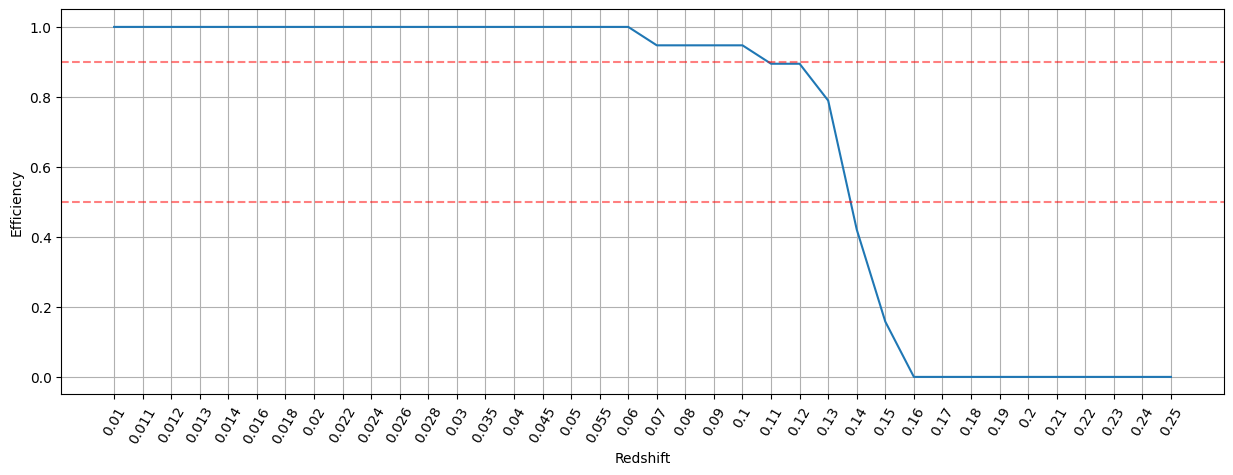

In [7]:
mlist,z50,z90 = calculate_efficiency_distance(24.5, plot=True, verbose=False)